<a href="https://colab.research.google.com/github/TarnNished/deep_learning_final/blob/main/data_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Storyteller — Data & Training

Full training notebook for image captioning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import random
from collections import Counter
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CONFIG = {
    "image_size": 224,
    "embedding_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1,
    "batch_size": 32,
    "lr": 1e-3,
    "epochs": 30,
    "max_len": 30,
    "min_word_freq": 2
}


In [4]:
if torch.cuda.is_available():
    print("using gpu")

using gpu


In [5]:
DATA_ROOT = "/content/drive/MyDrive/caption_data"
IMAGE_DIR = os.path.join(DATA_ROOT, "Images")
CAPTIONS_FILE = os.path.join(DATA_ROOT, "captions.txt")
ARTIFACTS_DIR = "/content/drive/MyDrive/visual-storyteller/artifacts"


In [6]:
torch.backends.cudnn.benchmark = True

def load_captions(image_dir, captions_file):

    samples = []

    with open(captions_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # remove header if exists
    if lines[0].lower().startswith("image"):
        lines = lines[1:]

    for line in lines:
        image_name, caption = line.strip().split(",", 1)
        image_path = os.path.join(image_dir, image_name)

        if os.path.exists(image_path):
            samples.append((image_path, caption.lower()))

    return samples


In [7]:
all_samples = load_captions(IMAGE_DIR, CAPTIONS_FILE)
print("Total (image, caption) pairs:", len(all_samples))


Total (image, caption) pairs: 40455


In [8]:

random.shuffle(all_samples)
train_end = int(0.8 * len(all_samples))
val_end = int(0.9 * len(all_samples))
train_data = all_samples[:train_end]
val_data = all_samples[train_end:val_end]
test_data = all_samples[val_end:]


In [9]:

SPECIAL_TOKENS = {"<pad>":0,"<bos>":1,"<eos>":2,"<unk>":3}

def build_vocab(captions, min_freq):
    counter = Counter()
    for c in captions:
        counter.update(c.split())
    vocab = dict(SPECIAL_TOKENS)
    idx = len(vocab)
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

vocab = build_vocab([c for _, c in train_data], CONFIG["min_word_freq"])
ivocab = {i:w for w,i in vocab.items()}
vocab_size = len(vocab)


In [10]:

def encode_caption(caption, vocab, max_len):
    tokens = caption.split()
    encoded = [vocab.get(w, vocab["<unk>"]) for w in tokens]
    encoded = [vocab["<bos>"]] + encoded + [vocab["<eos>"]]
    encoded = encoded[:max_len]
    encoded += [vocab["<pad>"]] * (max_len - len(encoded))
    return torch.tensor(encoded)


In [11]:

class CaptionDataset(Dataset):
    def __init__(self, data, vocab, transform):
        self.data = data
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        cap = encode_caption(caption, self.vocab, CONFIG["max_len"])
        return img, cap


In [12]:

transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_loader = DataLoader(
    CaptionDataset(train_data, vocab, transform),
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:

class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        resnet = models.resnet18(pretrained=True)

        # Remove classification head
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Project CNN features → embedding space
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)

    def forward(self, images):
        """
        images: (B, 3, H, W)
        returns: (B, embed_dim)
        """
         # freeze CNN
        feats = self.backbone(images)          # (B, 512, 1, 1)
        feats = feats.squeeze(-1).squeeze(-1)  # (B, 512)

        return self.fc(feats)                      # (B, embed_dim)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        """
        features: (B, embed_dim)
        captions: (B, T)

        Training input sequence:
        [image_feature, <bos>, word1, word2, ...]
        """

        # Remove <eos> from input
        emb = self.embedding(captions[:, :-1])  # (B, T-1, E)

        # Image as first timestep
        features = features.unsqueeze(1)         # (B, 1, E)

        # Concatenate
        x = torch.cat((features, emb), dim=1)    # (B, T, E)

        out, _ = self.lstm(x)                     # (B, T, H)
        logits = self.fc(out)                     # (B, T, vocab)

        return logits


In [14]:

encoder = Encoder(CONFIG["embedding_dim"]).to(DEVICE)
decoder = Decoder(vocab_size, CONFIG["embedding_dim"], CONFIG["hidden_dim"]).to(DEVICE)
# Freeze all CNN layers first
for p in encoder.backbone.parameters():
    p.requires_grad = False

# Unfreeze last ResNet blocks (fine-tuning)
for p in encoder.backbone[-1:].parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [15]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: Tesla T4


In [16]:

train_losses = []
for epoch in range(CONFIG["epochs"]):
    encoder.eval()
    decoder.train()
    total_loss = 0
    for images, captions in tqdm(train_loader):
        images, captions = images.to(DEVICE), captions.to(DEVICE)
        feats = encoder(images)
        outputs = decoder(feats, captions)
        loss = criterion(
          outputs[:, 1:, :].reshape(-1, vocab_size),
          captions[:, 1:].reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(train_loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}: loss={avg:.4f}")


100%|██████████| 1012/1012 [08:21<00:00,  2.02it/s]


Epoch 1: loss=4.4484


100%|██████████| 1012/1012 [03:53<00:00,  4.33it/s]


Epoch 2: loss=3.6393


100%|██████████| 1012/1012 [03:53<00:00,  4.34it/s]


Epoch 3: loss=3.3567


100%|██████████| 1012/1012 [03:55<00:00,  4.30it/s]


Epoch 4: loss=3.1666


100%|██████████| 1012/1012 [03:53<00:00,  4.33it/s]


Epoch 5: loss=3.0243


100%|██████████| 1012/1012 [03:55<00:00,  4.30it/s]


Epoch 6: loss=2.9105


100%|██████████| 1012/1012 [03:51<00:00,  4.36it/s]


Epoch 7: loss=2.8147


100%|██████████| 1012/1012 [03:52<00:00,  4.35it/s]


Epoch 8: loss=2.7330


100%|██████████| 1012/1012 [03:51<00:00,  4.38it/s]


Epoch 9: loss=2.6606


100%|██████████| 1012/1012 [03:53<00:00,  4.34it/s]


Epoch 10: loss=2.5960


100%|██████████| 1012/1012 [03:53<00:00,  4.34it/s]


Epoch 11: loss=2.5359


100%|██████████| 1012/1012 [03:49<00:00,  4.40it/s]


Epoch 12: loss=2.4800


100%|██████████| 1012/1012 [03:51<00:00,  4.38it/s]


Epoch 13: loss=2.4282


100%|██████████| 1012/1012 [03:55<00:00,  4.30it/s]


Epoch 14: loss=2.3789


100%|██████████| 1012/1012 [03:53<00:00,  4.33it/s]


Epoch 15: loss=2.3317


100%|██████████| 1012/1012 [03:50<00:00,  4.38it/s]


Epoch 16: loss=2.2868


100%|██████████| 1012/1012 [03:52<00:00,  4.35it/s]


Epoch 17: loss=2.2425


100%|██████████| 1012/1012 [03:50<00:00,  4.38it/s]


Epoch 18: loss=2.2001


100%|██████████| 1012/1012 [03:51<00:00,  4.37it/s]


Epoch 19: loss=2.1590


100%|██████████| 1012/1012 [03:53<00:00,  4.32it/s]


Epoch 20: loss=2.1186


100%|██████████| 1012/1012 [03:53<00:00,  4.34it/s]


Epoch 21: loss=2.0800


100%|██████████| 1012/1012 [03:50<00:00,  4.38it/s]


Epoch 22: loss=2.0417


100%|██████████| 1012/1012 [03:50<00:00,  4.38it/s]


Epoch 23: loss=2.0036


100%|██████████| 1012/1012 [03:46<00:00,  4.47it/s]


Epoch 24: loss=1.9665


100%|██████████| 1012/1012 [03:47<00:00,  4.45it/s]


Epoch 25: loss=1.9301


100%|██████████| 1012/1012 [03:45<00:00,  4.50it/s]


Epoch 26: loss=1.8947


100%|██████████| 1012/1012 [03:48<00:00,  4.42it/s]


Epoch 27: loss=1.8595


100%|██████████| 1012/1012 [03:47<00:00,  4.45it/s]


Epoch 28: loss=1.8252


100%|██████████| 1012/1012 [03:46<00:00,  4.48it/s]


Epoch 29: loss=1.7908


100%|██████████| 1012/1012 [03:50<00:00,  4.39it/s]

Epoch 30: loss=1.7581


In [17]:
def evaluate(loader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in loader:
            images = images.to(DEVICE)
            captions = captions.to(DEVICE)

            feats = encoder(images)
            outputs = decoder(feats, captions)

            loss = criterion(
                outputs[:, 1:, :].reshape(-1, vocab_size),
                captions[:, 1:].reshape(-1)
            )
            total_loss += loss.item()

    return total_loss / len(loader)


In [18]:

os.makedirs("artifacts", exist_ok=True)
torch.save({"encoder":encoder.state_dict(),
            "decoder":decoder.state_dict()}, "artifacts/model.pt")
json.dump(vocab, open("artifacts/vocab.json","w"))
json.dump(CONFIG, open("artifacts/config.json","w"))
print("Saved artifacts")


Saved artifacts


In [19]:
encoder.eval()
decoder.eval()

encoder.to(DEVICE)
decoder.to(DEVICE)


Decoder(
  (embedding): Embedding(4802, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=4802, bias=True)
)

In [22]:
def generate_caption_one(image_path, max_len=30):
    encoder.eval()
    decoder.eval()

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        # Encode image
        features = encoder(image)            # (1, embed_dim)
        features = features.unsqueeze(1)     # (1, 1, embed_dim)

        # STEP 0 — image as first timestep (same as training)
        out, (h, c) = decoder.lstm(features)

        # Start token
        word = torch.tensor([[vocab["<bos>"]]], device=DEVICE)
        caption_words = []

        for _ in range(max_len):
            emb = decoder.embedding(word)          # (1, 1, embed_dim)
            out, (h, c) = decoder.lstm(emb, (h, c))
            scores = decoder.fc(out.squeeze(1))

            probs = torch.softmax(scores / 0.7, dim=1)
            predicted = torch.multinomial(probs, 1).squeeze(1)
            word = predicted.unsqueeze(1)

            token_id = predicted.item()
            if token_id == vocab["<eos>"]:
                break

            caption_words.append(ivocab.get(token_id, "<unk>"))

    return " ".join(caption_words)


Image exists: True


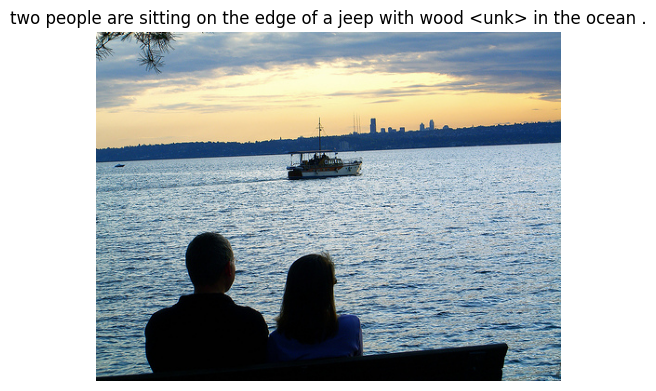

Generated caption: two people are sitting on the edge of a jeep with wood <unk> in the ocean .


In [25]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_path = "/content/drive/MyDrive/caption_data/Images/44129946_9eeb385d77.jpg"

# Sanity check: file exists
print("Image exists:", os.path.exists(image_path))

# Generate caption
caption = generate_caption_one(image_path)

# Display image with caption
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(caption)
plt.show()

print("Generated caption:", caption)
